## Intepreting Alphalens tear sheets

In the previous lesson, you learned how to query and process data so that we can analyze it with Alphalens tear sheets. In this lesson, you will experience a few iterations of the alpha discovery phase of the quant workflow by analyzing those tear sheets. In this lesson, we will: 
1. Analyze how well an alpha factor predicts future price movements with `create_information_tear_sheet()`.
2. Try to improve our original alpha factor by combining it with another alpha factor.
3. Preview the profitability of our alpha factor with `create_returns_tear_sheet()`.

## Our Starting Alpha Factors
The following code expresses an alpha factor based on a company's net income and market cap, and then creates an information tear sheet for that alpha factor. We will start analyzing the alpha factor by looking at it's information coefficient (IC). The IC is a number ranging from -1, to 1, which quantifies the predictiveness of an alpha factor. Any number above 0 is considered somewhat predictive.

The first number you should look at is the IC mean, which is an alpha factor's average IC over a given time period. You want your factor's IC Mean to be as high as possible. Generally speaking, a factor is worth investigating if it has an IC mean over 0. If it has an IC mean close to .1 (or higher) over a large trading universe, that factor is probably really good. 

In [1]:
from zipline.pipeline.fundamentals import Fundamentals

from zipline.pipeline import Pipeline
from zipline.research import run_pipeline
from zipline.pipeline.factors import CustomFactor, SimpleMovingAverage
# 自builtin导入
from zipline.pipeline.builtin import QTradableStocksUS
from zipline.pipeline.data import EquityPricing
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns


def make_pipeline():

    # 1 year moving average of year over year net income
    net_income_moving_average = SimpleMovingAverage(
      # 以营业利润代替
      inputs=[Fundamentals.ttm_profit_statement.营业利润],
      window_length=252
    )

    # 1 year moving average of market cap
    market_cap_moving_average = SimpleMovingAverage(
      inputs=[EquityPricing.market_cap],
      window_length=252
    )

    average_market_cap_per_net_income = market_cap_moving_average / net_income_moving_average

    # the last quarter's net income
    net_income = Fundamentals.q_profit_statement.营业利润.latest

    projected_market_cap = average_market_cap_per_net_income * net_income

    return Pipeline(
      columns={'projected_market_cap': projected_market_cap},
      screen=QTradableStocksUS() & projected_market_cap.notnull()
    )

In [2]:
from zipline.research import get_pricing

In [3]:
factor_data = run_pipeline(make_pipeline(), '2016-1-1', '2019-1-1')
pricing_data = get_pricing(factor_data.index.levels[1], '2016-1-1', '2019-6-1', fields='open')
merged_data = get_clean_factor_and_forward_returns(factor_data, pricing_data)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Below is the first chart produced by create_information_tear_sheet(). Notice how the IC Mean figures are all positive. That is a good sign! 

信息系数分析


,1D,5D,10D
IC平均值,0.010,0.021,0.026
IC标准差,0.108,0.130,0.136
风险调整后的IC,0.089,0.161,0.195
t-统计(IC),NaN,4.352,5.271
p值(IC),NaN,0.000,0.000
IC偏度,NaN,0.256,0.035
IC峰度,NaN,-0.406,-0.629


<Figure size 1200x800 with 0 Axes>

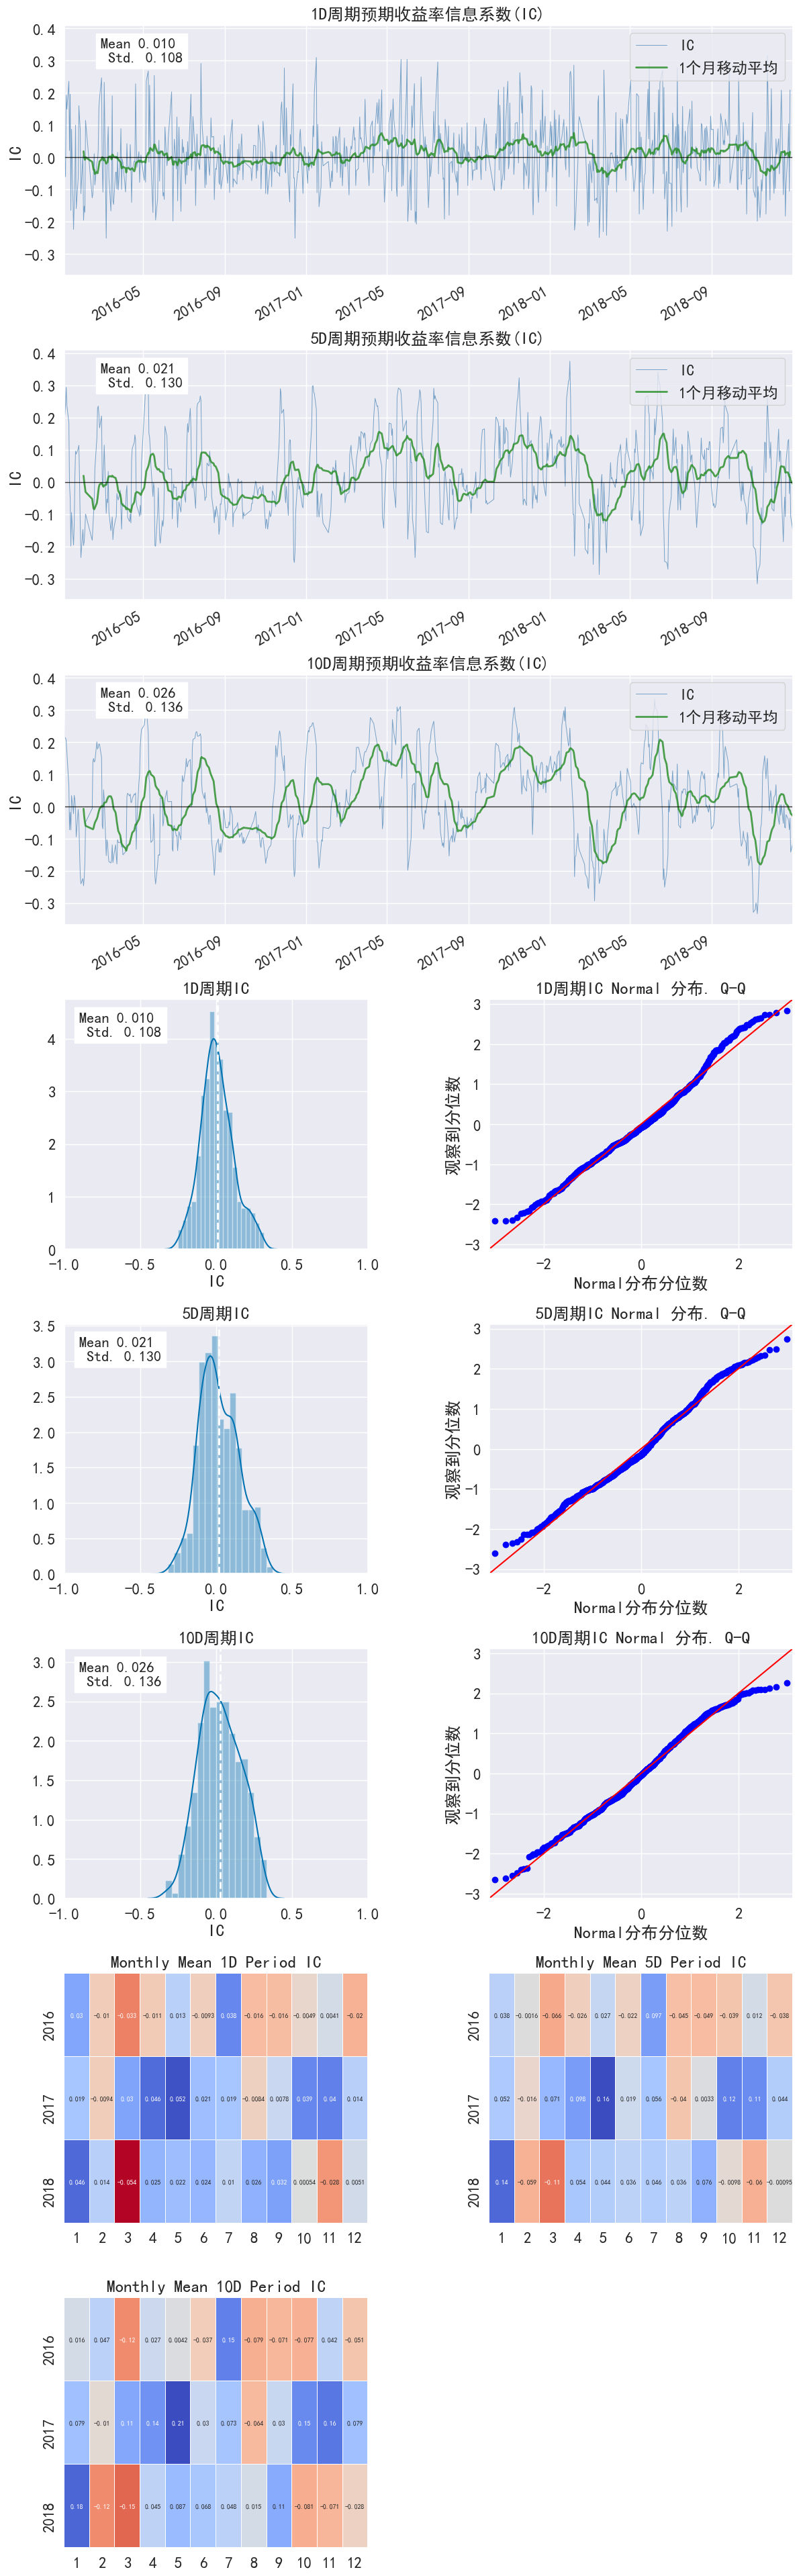

In [4]:
create_information_tear_sheet(merged_data)

## Add Another Alpha Factor
Alphalens is useful for identifying alpha factors that aren't predictive early in the quant workflow. This allows you to avoid wasting time running a full backtest on a factor that could have been discarded earlier in the process.

The following code expresses another alpha factor called price_to_book, combines it with `projected_market_cap` using zscores and winsorization, then creates another information tear sheet based on our new (and hopefully improved) alpha factor. 

In [5]:
class PriceToBook(CustomFactor):
    """收盘价与账面净资产比率"""
    inputs = (EquityPricing.close, Fundamentals.balance_sheet.所有者权益或股东权益合计)
    
    def compute(self, today, assets, out, close, net):
        out[:] = close[-1] / net[-1]

In [6]:
def make_pipeline():

    # 1 year moving average of year over year net income
    net_income_moving_average = SimpleMovingAverage(
      # 以营业利润代替
      inputs=[Fundamentals.ttm_profit_statement.营业利润],
      window_length=252
    )

    # 1 year moving average of market cap
    market_cap_moving_average = SimpleMovingAverage(
      inputs=[EquityPricing.market_cap],
      window_length=252
    )

    average_market_cap_per_net_income = (market_cap_moving_average / net_income_moving_average)

    # the last quarter's net income
    net_income = Fundamentals.q_profit_statement.营业利润.latest

    projected_market_cap = average_market_cap_per_net_income * net_income

    price_to_book = PriceToBook(window_length=1) # The alpha factor we are adding

    factor_to_analyze = projected_market_cap.zscore() + price_to_book.zscore()

    return Pipeline(
        columns={'factor_to_analyze': factor_to_analyze},
        screen=QTradableStocksUS() & factor_to_analyze.notnull()
    )

In [7]:
new_factor_data = run_pipeline(make_pipeline(), '2016-1-1', '2019-1-1')
new_pricing_data = get_pricing(new_factor_data.index.levels[1], '2016-1-1', '2019-6-1', fields='open')

In [8]:
new_merged_data = get_clean_factor_and_forward_returns(new_factor_data, new_pricing_data)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Notice how the IC figures are lower than they were in the first chart. That means the factor we added is making our predictions worse! 

信息系数分析


,1D,5D,10D
IC平均值,-0.000,-0.000,-0.002
IC标准差,0.089,0.103,0.109
风险调整后的IC,-0.004,-0.004,-0.018
t-统计(IC),NaN,-0.109,-0.494
p值(IC),NaN,0.913,0.621
IC偏度,NaN,-0.229,-0.532
IC峰度,NaN,0.320,0.774


<Figure size 1200x800 with 0 Axes>

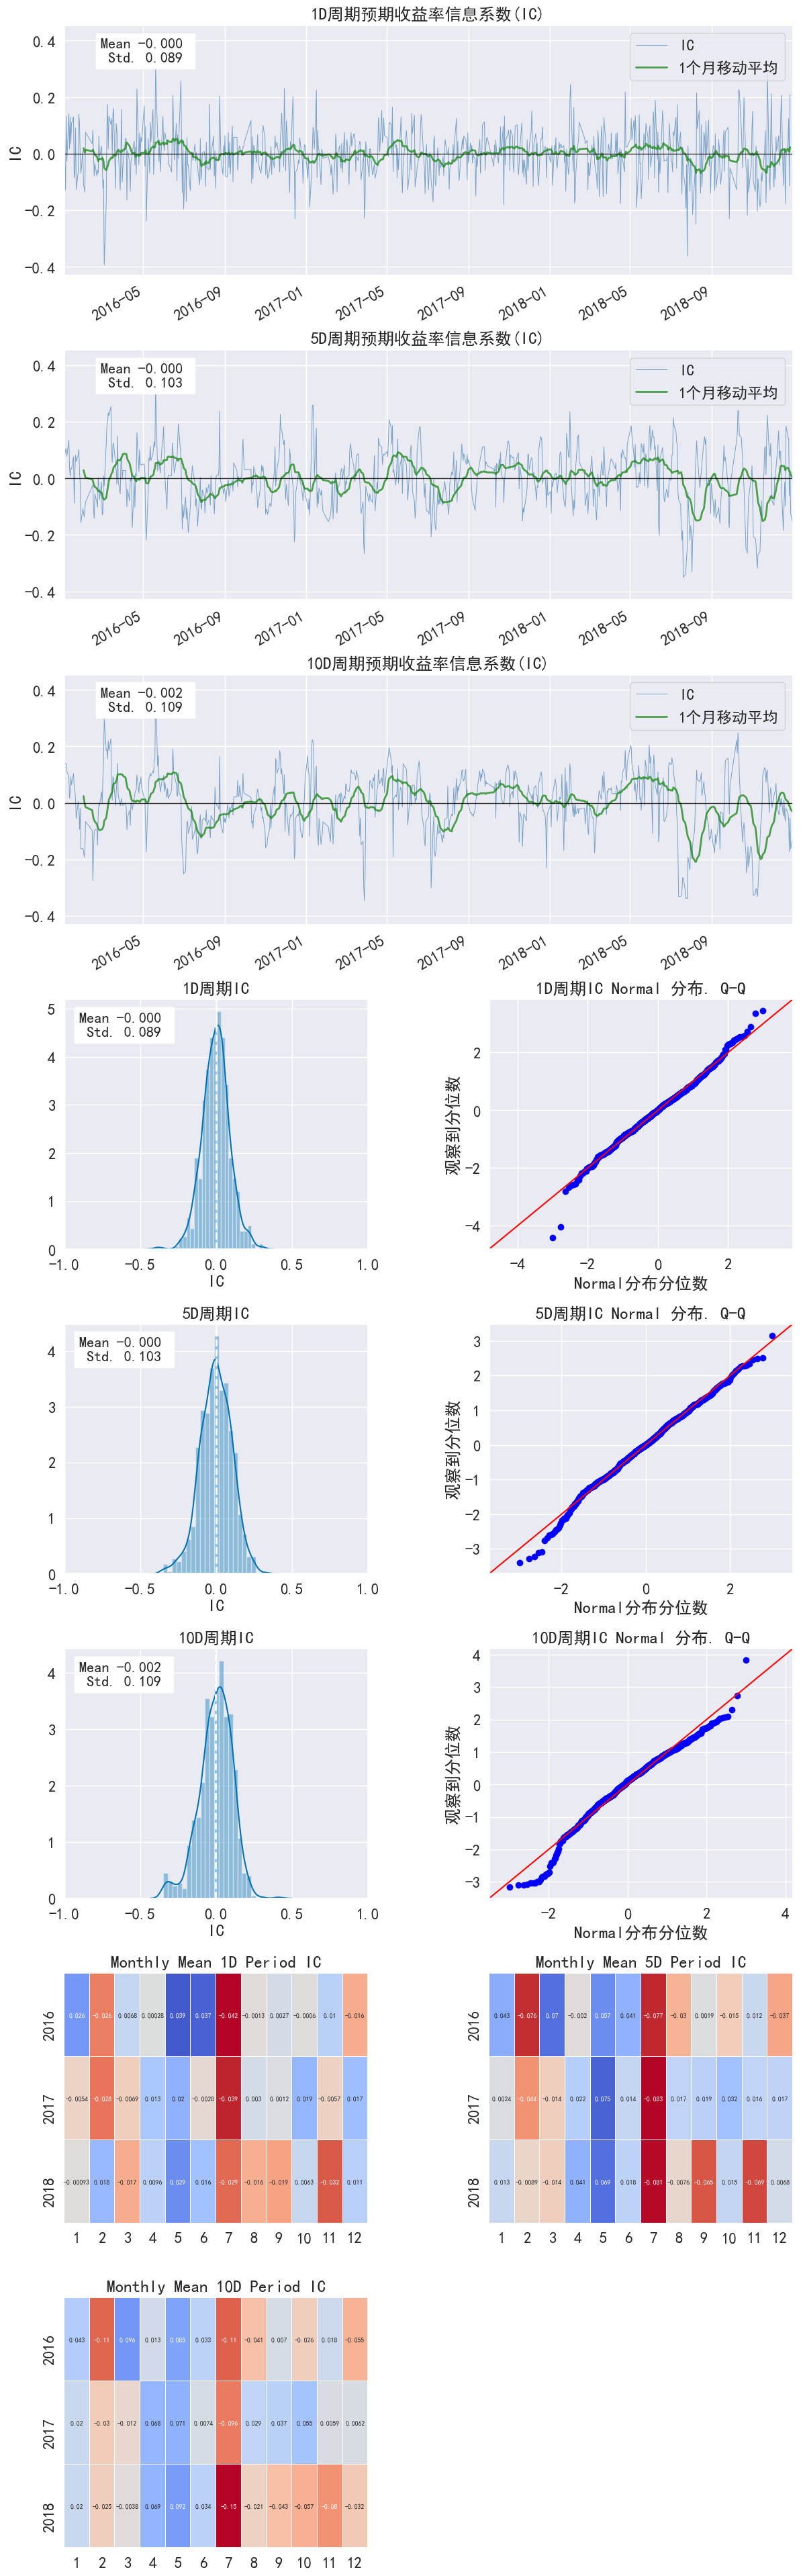

In [9]:
create_information_tear_sheet(new_merged_data)

In [10]:
# 按原文期间分析数据，发现`freq`不匹配问题。2010-2012-2期间交易日历有问题？？
# 启示，遇到问题时，更换数据期间来判断程序还是数据问题。

## See If Our Alpha Factor Might Be Profitable
We found that the first iteration of our alpha factor had more predictive value than the second one. Let's see if the original alpha factor might make any money.

`create_returns_tear_sheet()` splits your universe into quantiles, then shows the returns generated by each quantile over different time periods. Quantile 1 is the 20% of assets with the lowest alpha factor values, and quantile 5 is the highest 20%.

This function creates six types of charts, but the two most important ones are: 
+ Mean period-wise returns by factor quantile: This chart shows the average return for each quantile in your universe, per time period. You want the quantiles on the right to have higher average returns than the quantiles on the left.
+ Cumulative return by quantile: This chart shows you how each quantile performed over time. You want to see quantile 1 consistently performing the worst, quantile 5 consistently performing the best, and the other quantiles in the middle.

The following code creates a returns tear sheet. 

收益率分析


,1D,5D,10D
Ann. alpha,-0.022,-0.026,0.001
beta,-0.152,-0.187,-0.187
最高分位数周期平均收益率(基点),3.540,2.736,2.277
最低分位数周期平均收益率(基点),-1.536,-1.096,-0.951
周期平均展布(基点),5.076,3.778,3.171


<Figure size 1200x800 with 0 Axes>

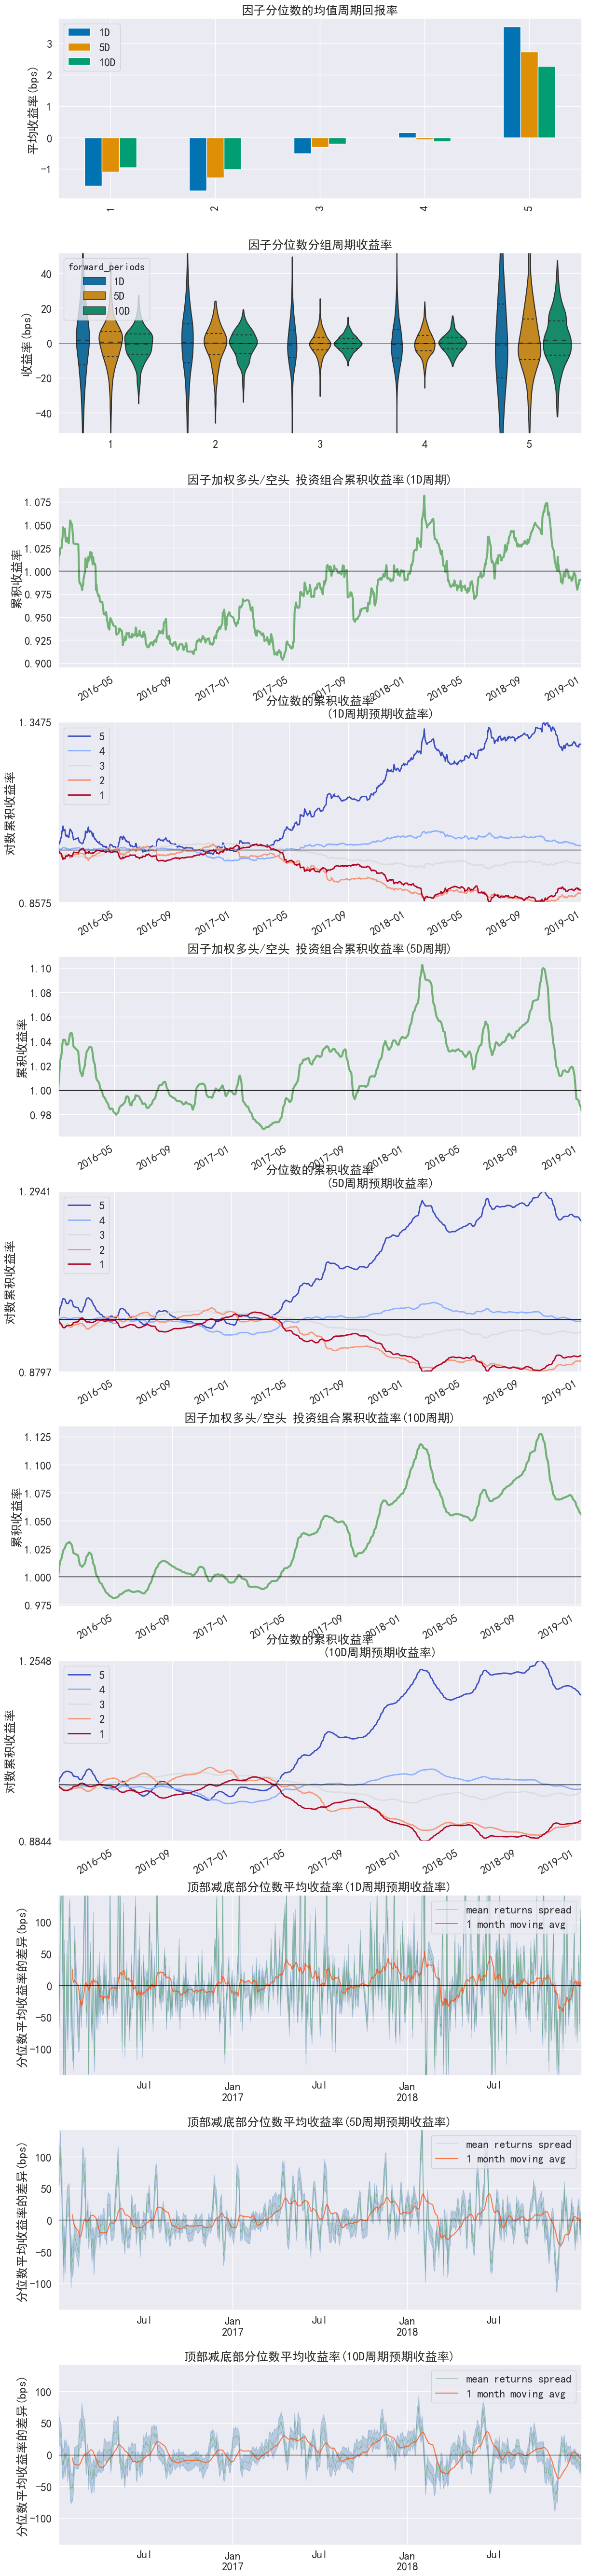

In [11]:
from alphalens.tears import create_returns_tear_sheet

create_returns_tear_sheet(merged_data)

Notice how quantile 5 doesn't have the highest returns. Ideally, you want quantile 1 to have the lowest returns, and quantile 5 to have the highest returns. Also, there is significant crossover between quantiles in the Cumulative Returns By Quantile chart. Ideally, there shouldn't be any crossover. This tear sheet is telling us we still have work to do! 

**以上为原文评述。**

**事实上，本文所构建的因子分位数收益率单调上升，即分位数1的收益率最低，而分位数5的收益率最高。IC平均值都大于0。可以说是一个较好的因子。**

In this lesson, you experienced a few cycles of the alpha discovery stage of the quant worfklow. Making good alpha factors isn't easy, but Alphalens allows you to iterate through them quickly to find out if you're on the right track! You can usually improve existing alpha factors in some way by getting creative with moving averages, looking for trend reversals, or any number of other stratgies.

Try looking around Quantopian's forums, or reading academic papers for inspiration. This is where you get to be creative! In the next lesson, we'll discuss advanced Alphalens concepts. 